In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
import seaborn as sns
from ExplainableMaximumLikelihoodCalculator import ExplainableMaximumLikelihoodCalculator
import pysam
from Bio import SeqIO, Seq, SeqRecord, pairwise2
from Bio.pairwise2 import format_alignment
from LoadDataUtils import getListOfReadsFromBamFile, getListOfReadsFromFastaFile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math
import shap
from scipy.stats import chisquare
from scipy.special import rel_entr
fileNameSapiens =  "data/simulatedData/human_chinese_AF346973_500samples.fas" #File that contains 500 reads from homo sapiens
fileNameNeanderthals =  "data/simulatedData/Neanderthal_Goyet_KX198085_500samples.fas" #File that contains 500 reads from neanderthal
fileNameDenisovans =  "data/simulatedData/denisova_kx663333_500samples.fas" #File that contains 500 reads from denisovan
neanderthals_500_generated = getListOfReadsFromFastaFile(fileNameNeanderthals)
sapiens_500_generated = getListOfReadsFromFastaFile(fileNameSapiens)
denisovan_500_samples = getListOfReadsFromFastaFile(fileNameDenisovans)
path_to_frequencies_table = "data/substitution_matrix.tsv"

2023-08-18 17:55:27.650302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 17:55:27.866910: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-18 17:55:27.901243: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-18 17:55:28.569123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
sapiens_reference_file_names = [
                    "data/reference_files/human_AF346981_French.fa",
                     "data/reference_files/human_AY195760_Korea.fa",
                      "data/reference_files/human_AY882416_Ethiopia.fa",
                      "data/reference_files/human_AY963586_Italian.fa",
                      "data/reference_files/human_AY195781_Caucasian.fa",
                      "data/reference_files/human_AY195757_Iraqi-Israeli.fa",
                      "data/reference_files/human_AY195749_NativeAmerican.fa"]
neanderthals_reference_file_names = [
                            "data/reference_files/neanderthal_mezmaiskaya1_FM865411.fa",
                           "data/reference_files/Neanderthal_Altai_KC879692.fa",
                           "data/reference_files/Neanderthal_Denisova11_full_mtDNA_KU131206.fa",
                           "data/reference_files/Neanderthal_Spy_94a_MG025538.fa",
                            "data/reference_files/Neanderthal_Vindija33.16_AM948965.fa",
                            "data/reference_files/Neanderthal_Vindija33.19_KJ533545.fa"]
denisovan_reference_file_names = [  
                        "data/reference_files/Denisova_MT576653.1.fa",
                        "data/reference_files/Denisova_MT576652.1.fa",
                        "data/reference_files/Denisova_4_FR695060.fa",
                        "data/reference_files/Denisova_8_KT780370.fa",
                        "data/reference_files/Denisova_manual_phalanx_NC_013993.fa",
                        "data/reference_files/Denisova_MT576651.1.fa"]

In [3]:
def generate_sample(sap, nean, den):
    list_before =  list(np.random.choice(sapiens_500_generated, sap)) + list(np.random.choice(neanderthals_500_generated, nean)) + list(np.random.choice(denisovan_500_samples, den))
    l = []
    for i in list_before:
        l.append(str(i))
    return l

In [4]:
sapiens = 33
neanderthals = 33
denisovans = 34

dataset_1 = generate_sample(sapiens, neanderthals, denisovans)

In [5]:
maximum_likelihood_calculator_d_1 = ExplainableMaximumLikelihoodCalculator(dataset_1,
                                                    ref_neanderthal_file_names=neanderthals_reference_file_names,
                                                    ref_sapien_file_names=sapiens_reference_file_names,
                                                    ref_denisovan_file_names=denisovan_reference_file_names,
                                                    path_to_substitution_matrix=path_to_frequencies_table,
                                                    number_of_jobs=-1)

Loading sequences and calculating alignments to all references, this might take a while. Number of reads:  100
start working on read number 0
start working on read number 40
start working on read number 80


In [9]:
maximum_likelihood_calculator_d_1.estimate_species_proportions()

,Homo Sapiens,Neanderthals,Denisovans
Estimation,0.375,0.3,0.325


In [12]:
def accuracy(values, ground_truth):
    count_correct = 0
    count = 0
    for label in range(3):
        
        values_in_label = values[label][0]
        gt_in_label = ground_truth[label][0]
        for i in range(len(gt_in_label)):
            if(values_in_label[i] * gt_in_label[i] > 0):
                count_correct +=1
            if (gt_in_label[i] != 0):
                count +=1
    return count_correct / count
    
    
    

In [27]:
data_shap = []
data_monte = []
data_a_s_d = []

In [26]:
ground_truth_shapleys = maximum_likelihood_calculator_d_1.calculate_shapley_values(50000)


1


  0%|          | 0/1 [00:00<?, ?it/s]

1
50000


In [29]:
sample_sizes = [100,200,300,1000,2000,5000,10000]
shap_values_all = []
for sp_size in sample_sizes:
    
    shaps = maximum_likelihood_calculator_d_1.calculate_shapley_values(sp_size)
    shap_values_all.append((sp_size, shaps))
    a_s_d = maximum_likelihood_calculator_d_1.get_A_s_d_values()
    first = [a[0]-0.33 for a in a_s_d]
    second = [a[1]-0.33 for a in a_s_d]
    third = [a[2]-0.33 for a in a_s_d]
    a_s_d_values = [[first], [second], [third]]
    
    sign_accuracy_shap = accuracy(shaps, ground_truth_shapleys)
    sign_accuracy_a_s_d = accuracy(a_s_d_values, ground_truth_shapleys)
    
    data_shap.append((sp_size, sign_accuracy_shap))
    data_a_s_d.append((sp_size, sign_accuracy_a_s_d))
                     
    print("shap", sign_accuracy_shap)
    print("asd",sign_accuracy_a_s_d)   

1


  0%|          | 0/1 [00:00<?, ?it/s]

1
100
shap 0.23770491803278687
asd 0.9918032786885246
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
200
shap 0.45901639344262296
asd 0.9918032786885246
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
300
shap 0.569672131147541
asd 0.9918032786885246
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
1000
shap 0.8770491803278688
asd 0.9918032786885246
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
2000
shap 0.9385245901639344
asd 0.9918032786885246
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
5000
shap 0.9795081967213115
asd 0.9918032786885246
1


  0%|          | 0/1 [00:00<?, ?it/s]

1
10000
shap 0.9959016393442623
asd 0.9918032786885246


In [30]:
def plot(t,s, name, title):

    plt.rcParams.update({'font.size': 14})
    plt.plot(t, s)
    plt.title(title)
    plt.xlabel("Number of samples per sequence")
    plt.ylabel("Percentage of correct explanation values")
    
    plt.savefig(name)

    plt.show()

In [34]:
a_s_d_values = [[first], [second], [third]]

In [42]:
a_s_d_values[0][0][10:15]

[-0.030000000000000027,
 0.09853420334862567,
 0.6069157971907466,
 0.1699240034541737,
 0.11691946052439772]

In [ ]:
a_s_d_values

In [33]:
ground_truth_shapleys

[array([[ 0.00966442,  0.06209407,  0.06292429,  0.06142197,  0.0130092 ,
          0.06273227, -0.01202781,  0.05691427,  0.        ,  0.05255409,
         -0.00567986,  0.00582976,  0.05868052,  0.01248213,  0.00861536,
          0.00784802,  0.06307841,  0.        , -0.00593208,  0.0065408 ,
          0.00821448,  0.        ,  0.05307939,  0.06015497,  0.05700323,
          0.01696073,  0.06486103,  0.00981173,  0.05992319,  0.06186784,
          0.06439617,  0.00716243,  0.06248518,  0.02662432, -0.02304263,
          0.        ,  0.03286785, -0.04163797,  0.        , -0.03970657,
          0.        , -0.03586067, -0.03814565,  0.        , -0.03920505,
         -0.0361143 , -0.03866634, -0.04128026,  0.00934065, -0.03898429,
          0.        , -0.03975389,  0.        , -0.03881415,  0.        ,
         -0.03882951,  0.        , -0.00554762, -0.02100386,  0.        ,
          0.        ,  0.        , -0.0377255 ,  0.01515282,  0.00881026,
          0.        , -0.02618209, -0.

<Figure size 640x480 with 0 Axes>

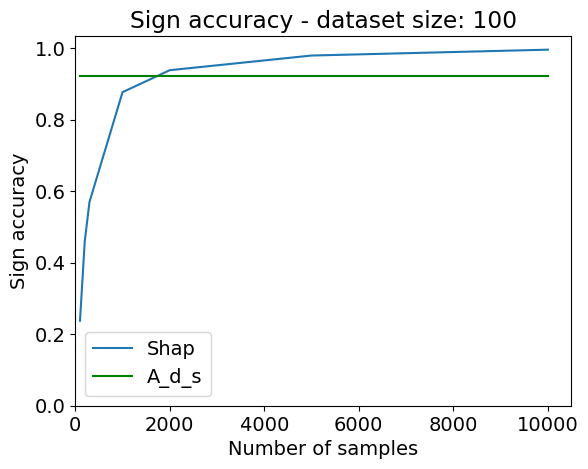

In [48]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})
t = [i[0] for i in data_shap]
plt.plot(t,[i[1] for i in data_shap],label='Shap')
plt.plot(t,[i[1] for i in data_a_s_d ],label='A_d_s', color="green")
plt.title("Sign accuracy - dataset size: 100")
plt.xlabel("Number of samples")
plt.ylabel("Sign accuracy")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("sign_accuracy_larger_dataset.png")
plt.show()



In [43]:
data_shap

[(100, 0.23770491803278687),
 (200, 0.45901639344262296),
 (300, 0.569672131147541),
 (1000, 0.8770491803278688),
 (2000, 0.9385245901639344),
 (5000, 0.9795081967213115),
 (10000, 0.9959016393442623)]

In [45]:
data_a_s_d = [(i[0],0.9218032786885246) for i in data_a_s_d ]

In [46]:
data_a_s_d

[(100, 0.9218032786885246),
 (200, 0.9218032786885246),
 (300, 0.9218032786885246),
 (1000, 0.9218032786885246),
 (2000, 0.9218032786885246),
 (5000, 0.9218032786885246),
 (10000, 0.9218032786885246)]

In [49]:
def dcg_of_item(actual_location, desired_location, length):
    distance = np.abs(actual_location - desired_location)
    score = length - distance
    # the closer you are the higher the score
    denominator = np.log2(actual_location+1)
    return score/denominator
    

In [50]:
def calculate_score_of_ranking(desired_ranking, actual_ranking):
    score_sum = 0
    for i in range(len(desired_ranking)):
        item = actual_ranking[i] # this is the item that was in the ith place
        desired_rank_of_item = desired_ranking.index(item)+1
        score = dcg_of_item(i+1, desired_rank_of_item, len(desired_ranking))
        score_sum += score
    return score_sum

In [51]:
def calculate_ideal_score(size):
    ideal_list = list(range(size))
    return calculate_score_of_ranking(ideal_list,ideal_list)

In [52]:
only_indexes_sorted = [i[1] for i in ground_truth_shapleys]

IndexError: index 1 is out of bounds for axis 0 with size 1

In [66]:
def get_ranking_score_per_label(label, ground_truth, estimation):
    ground_truth_shapley_label = ground_truth[label][0]
    ground_shapley_label_with_index = []
    for i in range(len(ground_truth_shapley_label)):
        ground_shapley_label_with_index.append((ground_truth_shapley_label[i], i))
    ground_shapley_label_with_index_sorted = sorted(ground_shapley_label_with_index, key=lambda a:a[0], reverse=True)
    only_indexes_sorted = [i[1] for i in ground_shapley_label_with_index_sorted]

    estimation_label = estimation[label][0]
    estimation_with_index = []
    for i in range(len(shaps_label)):
        estimation_with_index.append((estimation_label[i], i))
    estimation_label_with_index_sorted = sorted(estimation_with_index, key=lambda a:a[0], reverse=True)
    only_indexes_sorted_estimation = [i[1] for i in estimation_label_with_index_sorted]
    ranking_result_shap = calculate_score_of_ranking(only_indexes_sorted, only_indexes_sorted_estimation)
    ideal_score = calculate_ideal_score(len(ground_truth[0][0]))
    return ranking_result_shap/ideal_score

In [83]:
to_plot_shaps = []
to_plot_a_d_s = []
for (size, shaps) in shap_values_all:
    scores = []
    for label in range(3):
        score = get_ranking_score_per_label(label, ground_truth_shapleys, shaps)
        scores.append(score)
    to_plot_shaps.append((size, np.mean(scores)))
    to_plot_a_d_s.append((size, 0.8978417055473319))
    
    

In [84]:
to_plot_shaps

[(100, 0.7323964924853962),
 (200, 0.7789463108926635),
 (300, 0.826754481322622),
 (1000, 0.9075217015212393),
 (2000, 0.9212735718611563),
 (5000, 0.9364038655783883),
 (10000, 0.94517749185971)]

In [85]:
to_plot_a_d_s

[(100, 0.8978417055473319),
 (200, 0.8978417055473319),
 (300, 0.8978417055473319),
 (1000, 0.8978417055473319),
 (2000, 0.8978417055473319),
 (5000, 0.8978417055473319),
 (10000, 0.8978417055473319)]

<Figure size 640x480 with 0 Axes>

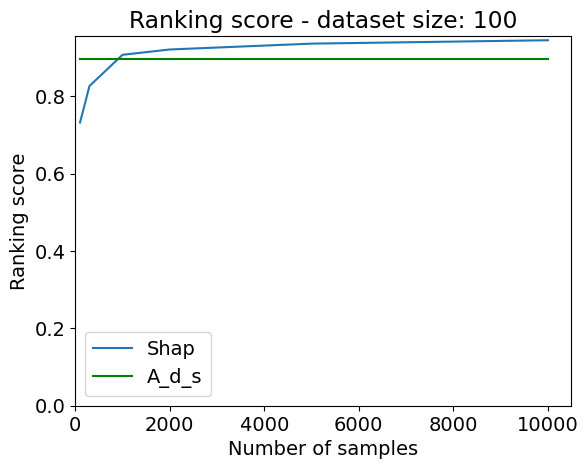

In [87]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure() 
plt.figure().clear()
plt.rcParams.update({'font.size': 14})
t = [i[0] for i in to_plot_shaps]
plt.plot(t,[i[1] for i in to_plot_shaps],label='Shap')
plt.plot(t,[i[1] for i in to_plot_a_d_s ],label='A_d_s', color="green")
plt.title("Ranking score - dataset size: 100")
plt.xlabel("Number of samples")
plt.ylabel("Ranking score")
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.legend()
plt.savefig("ranking_score_larger_dataset.png")
plt.show()
